# Set-up Environment

In [1]:
spark.version

'3.1.3'

In [2]:
import os
import pandas as pd
import numpy as np

from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
warnings.filterwarnings(action = 'ignore')

In [3]:
!pip3 install nltk -U

In [4]:
import re
import json
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer, IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.cloud import storage

spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

## Set-up COS functions for GCP

In [6]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix = folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns = ['Name','Size'])

    #blobs_df = blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [7]:
# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix = folder_name))

    for blob in blobs:
        blob.delete()

In [8]:
# Reading data from bucket
bucket = 'shijia-bdp-class'

# Read Preprocessed Data Parquet Files

In [9]:
blob_list = list_blobs_pd(bucket, 'inter_result/preprocessed')

In [10]:
blob_list.head(10)

,Name,Size
0,inter_result/preprocessed/,0
1,inter_result/preprocessed/_SUCCESS,0
2,inter_result/preprocessed/part-00000-3fc5e83a-6175-43e3-991a-856d1db34d85-c000.snappy.parquet,6714906
3,inter_result/preprocessed/part-00001-3fc5e83a-6175-43e3-991a-856d1db34d85-c000.snappy.parquet,6544339
4,inter_result/preprocessed/part-00002-3fc5e83a-6175-43e3-991a-856d1db34d85-c000.snappy.parquet,6374015
5,inter_result/preprocessed/part-00003-3fc5e83a-6175-43e3-991a-856d1db34d85-c000.snappy.parquet,6498634
6,inter_result/preprocessed/part-00004-3fc5e83a-6175-43e3-991a-856d1db34d85-c000.snappy.parquet,6419798
7,inter_result/preprocessed/part-00005-3fc5e83a-6175-43e3-991a-856d1db34d85-c000.snappy.parquet,6568402
8,inter_result/preprocessed/part-00006-3fc5e83a-6175-43e3-991a-856d1db34d85-c000.snappy.parquet,6605609
9,inter_result/preprocessed/part-00007-3fc5e83a-6175-43e3-991a-856d1db34d85-c000.snappy.parquet,6386363


In [11]:
path = 'gs://shijia-bdp-class/inter_result/preprocessed'
tweets_processed = spark.read.parquet(path)

In [12]:
tweets_processed.printSchema()

root
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- protected: boolean (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |    |-- statuses_count: long (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |-- quote_c

In [13]:
tweets_processed.count()

99992797

In [14]:
tweets_processed.limit(20)

coordinates,created_at,id,text,user,quote_count,reply_count,favorite_count,retweet_count,retweeted,retweeted_from,retweeted_status
null,Tue May 03 00:12:...,1521281587765145602,RT @KhalifaKeith2...,{Tue Apr 23 03:33...,0,0,0,0,RT,KhalifaKeith2,"{null, Mon May 02..."
null,Tue May 03 00:12:...,1521281588016955393,RT @80s_Kidz: Who...,{Tue Aug 15 22:25...,0,0,0,0,RT,80s_Kidz,"{null, Sun May 01..."
null,Tue May 03 00:12:...,1521281589438689280,@PuccaNoodles Sam...,{Thu May 28 20:19...,0,0,0,0,,null,null
null,Tue May 03 00:12:...,1521281590051192834,RT @ColeHooverEIU...,{Thu Dec 23 02:07...,0,0,0,0,RT,ColeHooverEIU,"{null, Mon May 02..."
null,Tue May 03 00:12:...,1521281590072320000,good morning 🥺🥺...,{Tue Dec 26 15:24...,0,0,0,0,,null,null
null,Tue May 03 00:12:...,1521281590357331975,@SportCommenter @...,{Sun Sep 26 10:41...,0,0,0,0,,stateoffl @thetri...,null
null,Tue May 03 00:12:...,1521281588729827328,i hate my school ...,{Mon Mar 16 17:20...,0,0,0,0,,null,null
null,Tue May 03 00:12:...,1521281592299245568,RT @kit_connor: p...,{Wed Nov 24 21:49...,0,0,0,0,RT,kit_connor,"{null, Mon May 02..."
null,Tue May 03 00:12:...,1521281591355531267,Finding the perfe...,{Thu Apr 09 01:04...,0,0,0,0,,null,null
null,Tue May 03 00:12:...,1521281593997996034,@realEstateTrent ...,{Fri Dec 11 00:59...,0,0,0,0,,null,null


# Clean Tweets Text

## Lowercasing all the letters¶

In [15]:
tweets_cleaned = tweets_processed.withColumn('cleaned_text', lower(col('text')))

tweets_cleaned.select('text', 'cleaned_text').limit(20).toPandas()

,text,cleaned_text
0,RT @ArshWariana: Once there used to be good quality govt colleges in Punjab.This statement is going to be true if this recruitment doesn't…,rt @arshwariana: once there used to be good quality govt colleges in punjab.this statement is going to be true if this recruitment doesn't…
1,RT @IGTWEETTV: Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.c…,rt @igtweettv: me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nbreakfast: https://t.c…
2,@light_chariot I'm with this guy - something is extremely sus about this. I went to the ShitCo Growth Stock School… https://t.co/jcvSq4SxBw,@light_chariot i'm with this guy - something is extremely sus about this. i went to the shitco growth stock school… https://t.co/jcvsq4sxbw
3,Our first outdoor visit at #supermarket Amazing gesture showed by our little ones 👏👏\nA big thanks to the staff of D… https://t.co/xtmFjyvZIU,our first outdoor visit at #supermarket amazing gesture showed by our little ones 👏👏\na big thanks to the staff of d… https://t.co/xtmfjyvziu
4,RT @ripx4nutmeg: News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake breasts wit…,rt @ripx4nutmeg: news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit…
5,RT @republic: #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have to raise i…,rt @republic: #breaking | my heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. i have to raise i…
6,2023 Medical Fellowship for African Medical Practitioners at Aga Khan University in Kenya https://t.co/1tlkYhY6j0,2023 medical fellowship for african medical practitioners at aga khan university in kenya https://t.co/1tlkyhy6j0
7,Scar playing with Mufasa’s skull was iconic. They used to have us watch Disney movies in the auditorium during the… https://t.co/ApbdqZBjGz,scar playing with mufasa’s skull was iconic. they used to have us watch disney movies in the auditorium during the… https://t.co/apbdqzbjgz
8,RT @StefanoBloch: Professors. You assign too much reading. It doesn't help. Assign less so students (graduate and undergraduate) can actual…,rt @stefanobloch: professors. you assign too much reading. it doesn't help. assign less so students (graduate and undergraduate) can actual…
9,Hamady vs Madison Academy | Today's Michigan High School Football Live Stream\nWatch live Broadcast Here🏈 :… https://t.co/bX5aUySq8z,hamady vs madison academy | today's michigan high school football live stream\nwatch live broadcast here🏈 :… https://t.co/bx5auysq8z


## Removing hashtags and mentions

In [16]:
# remove mentions
tweets_cleaned = tweets_cleaned.withColumn('cleaned_text', regexp_replace(tweets_cleaned["cleaned_text"], "@[A-Za-z0-9_]+", ""))

tweets_cleaned.select('text', 'cleaned_text').limit(20).toPandas()

,text,cleaned_text
0,RT @ArshWariana: Once there used to be good quality govt colleges in Punjab.This statement is going to be true if this recruitment doesn't…,rt : once there used to be good quality govt colleges in punjab.this statement is going to be true if this recruitment doesn't…
1,RT @IGTWEETTV: Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.c…,rt : me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nbreakfast: https://t.c…
2,@light_chariot I'm with this guy - something is extremely sus about this. I went to the ShitCo Growth Stock School… https://t.co/jcvSq4SxBw,i'm with this guy - something is extremely sus about this. i went to the shitco growth stock school… https://t.co/jcvsq4sxbw
3,Our first outdoor visit at #supermarket Amazing gesture showed by our little ones 👏👏\nA big thanks to the staff of D… https://t.co/xtmFjyvZIU,our first outdoor visit at #supermarket amazing gesture showed by our little ones 👏👏\na big thanks to the staff of d… https://t.co/xtmfjyvziu
4,RT @ripx4nutmeg: News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake breasts wit…,rt : news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit…
5,RT @republic: #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have to raise i…,rt : #breaking | my heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. i have to raise i…
6,2023 Medical Fellowship for African Medical Practitioners at Aga Khan University in Kenya https://t.co/1tlkYhY6j0,2023 medical fellowship for african medical practitioners at aga khan university in kenya https://t.co/1tlkyhy6j0
7,Scar playing with Mufasa’s skull was iconic. They used to have us watch Disney movies in the auditorium during the… https://t.co/ApbdqZBjGz,scar playing with mufasa’s skull was iconic. they used to have us watch disney movies in the auditorium during the… https://t.co/apbdqzbjgz
8,RT @StefanoBloch: Professors. You assign too much reading. It doesn't help. Assign less so students (graduate and undergraduate) can actual…,rt : professors. you assign too much reading. it doesn't help. assign less so students (graduate and undergraduate) can actual…
9,Hamady vs Madison Academy | Today's Michigan High School Football Live Stream\nWatch live Broadcast Here🏈 :… https://t.co/bX5aUySq8z,hamady vs madison academy | today's michigan high school football live stream\nwatch live broadcast here🏈 :… https://t.co/bx5auysq8z


In [17]:
# remove hashtags
tweets_cleaned = tweets_cleaned.withColumn('cleaned_text', regexp_replace(tweets_cleaned["cleaned_text"], "#[A-Za-z0-9_]+", ""))

tweets_cleaned.select('text', 'cleaned_text').limit(20).toPandas()

,text,cleaned_text
0,RT @ArshWariana: Once there used to be good quality govt colleges in Punjab.This statement is going to be true if this recruitment doesn't…,rt : once there used to be good quality govt colleges in punjab.this statement is going to be true if this recruitment doesn't…
1,RT @IGTWEETTV: Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.c…,rt : me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nbreakfast: https://t.c…
2,@light_chariot I'm with this guy - something is extremely sus about this. I went to the ShitCo Growth Stock School… https://t.co/jcvSq4SxBw,i'm with this guy - something is extremely sus about this. i went to the shitco growth stock school… https://t.co/jcvsq4sxbw
3,Our first outdoor visit at #supermarket Amazing gesture showed by our little ones 👏👏\nA big thanks to the staff of D… https://t.co/xtmFjyvZIU,our first outdoor visit at amazing gesture showed by our little ones 👏👏\na big thanks to the staff of d… https://t.co/xtmfjyvziu
4,RT @ripx4nutmeg: News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake breasts wit…,rt : news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit…
5,RT @republic: #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have to raise i…,rt : | my heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. i have to raise i…
6,2023 Medical Fellowship for African Medical Practitioners at Aga Khan University in Kenya https://t.co/1tlkYhY6j0,2023 medical fellowship for african medical practitioners at aga khan university in kenya https://t.co/1tlkyhy6j0
7,Scar playing with Mufasa’s skull was iconic. They used to have us watch Disney movies in the auditorium during the… https://t.co/ApbdqZBjGz,scar playing with mufasa’s skull was iconic. they used to have us watch disney movies in the auditorium during the… https://t.co/apbdqzbjgz
8,RT @StefanoBloch: Professors. You assign too much reading. It doesn't help. Assign less so students (graduate and undergraduate) can actual…,rt : professors. you assign too much reading. it doesn't help. assign less so students (graduate and undergraduate) can actual…
9,Hamady vs Madison Academy | Today's Michigan High School Football Live Stream\nWatch live Broadcast Here🏈 :… https://t.co/bX5aUySq8z,hamady vs madison academy | today's michigan high school football live stream\nwatch live broadcast here🏈 :… https://t.co/bx5auysq8z


## Removing links

In [18]:
tweets_cleaned = tweets_cleaned.withColumn('cleaned_text', regexp_replace(tweets_cleaned["cleaned_text"], r"http\S+", ""))
tweets_cleaned = tweets_cleaned.withColumn('cleaned_text', regexp_replace(tweets_cleaned["cleaned_text"], r"www.\S+", ""))

tweets_cleaned.select('text', 'cleaned_text').limit(20).toPandas()

,text,cleaned_text
0,RT @ArshWariana: Once there used to be good quality govt colleges in Punjab.This statement is going to be true if this recruitment doesn't…,rt : once there used to be good quality govt colleges in punjab.this statement is going to be true if this recruitment doesn't…
1,RT @IGTWEETTV: Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.c…,rt : me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nbreakfast:
2,@light_chariot I'm with this guy - something is extremely sus about this. I went to the ShitCo Growth Stock School… https://t.co/jcvSq4SxBw,i'm with this guy - something is extremely sus about this. i went to the shitco growth stock school…
3,Our first outdoor visit at #supermarket Amazing gesture showed by our little ones 👏👏\nA big thanks to the staff of D… https://t.co/xtmFjyvZIU,our first outdoor visit at amazing gesture showed by our little ones 👏👏\na big thanks to the staff of d…
4,RT @ripx4nutmeg: News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake breasts wit…,rt : news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit…
5,RT @republic: #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have to raise i…,rt : | my heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. i have to raise i…
6,2023 Medical Fellowship for African Medical Practitioners at Aga Khan University in Kenya https://t.co/1tlkYhY6j0,2023 medical fellowship for african medical practitioners at aga khan university in kenya
7,Scar playing with Mufasa’s skull was iconic. They used to have us watch Disney movies in the auditorium during the… https://t.co/ApbdqZBjGz,scar playing with mufasa’s skull was iconic. they used to have us watch disney movies in the auditorium during the…
8,RT @StefanoBloch: Professors. You assign too much reading. It doesn't help. Assign less so students (graduate and undergraduate) can actual…,rt : professors. you assign too much reading. it doesn't help. assign less so students (graduate and undergraduate) can actual…
9,Hamady vs Madison Academy | Today's Michigan High School Football Live Stream\nWatch live Broadcast Here🏈 :… https://t.co/bX5aUySq8z,hamady vs madison academy | today's michigan high school football live stream\nwatch live broadcast here🏈 :…


## Removing punctuations

In [19]:
tweets_cleaned = tweets_cleaned.withColumn('cleaned_text', regexp_replace(tweets_cleaned["cleaned_text"], "[()!?]", ""))
tweets_cleaned = tweets_cleaned.withColumn('cleaned_text', regexp_replace(tweets_cleaned["cleaned_text"], "\[.*?\]", ""))

tweets_cleaned.select('text', 'cleaned_text').limit(20).toPandas()

,text,cleaned_text
0,RT @ArshWariana: Once there used to be good quality govt colleges in Punjab.This statement is going to be true if this recruitment doesn't…,rt : once there used to be good quality govt colleges in punjab.this statement is going to be true if this recruitment doesn't…
1,RT @IGTWEETTV: Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.c…,rt : me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nbreakfast:
2,@light_chariot I'm with this guy - something is extremely sus about this. I went to the ShitCo Growth Stock School… https://t.co/jcvSq4SxBw,i'm with this guy - something is extremely sus about this. i went to the shitco growth stock school…
3,Our first outdoor visit at #supermarket Amazing gesture showed by our little ones 👏👏\nA big thanks to the staff of D… https://t.co/xtmFjyvZIU,our first outdoor visit at amazing gesture showed by our little ones 👏👏\na big thanks to the staff of d…
4,RT @ripx4nutmeg: News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake breasts wit…,rt : news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit…
5,RT @republic: #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have to raise i…,rt : | my heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. i have to raise i…
6,2023 Medical Fellowship for African Medical Practitioners at Aga Khan University in Kenya https://t.co/1tlkYhY6j0,2023 medical fellowship for african medical practitioners at aga khan university in kenya
7,Scar playing with Mufasa’s skull was iconic. They used to have us watch Disney movies in the auditorium during the… https://t.co/ApbdqZBjGz,scar playing with mufasa’s skull was iconic. they used to have us watch disney movies in the auditorium during the…
8,RT @StefanoBloch: Professors. You assign too much reading. It doesn't help. Assign less so students (graduate and undergraduate) can actual…,rt : professors. you assign too much reading. it doesn't help. assign less so students graduate and undergraduate can actual…
9,Hamady vs Madison Academy | Today's Michigan High School Football Live Stream\nWatch live Broadcast Here🏈 :… https://t.co/bX5aUySq8z,hamady vs madison academy | today's michigan high school football live stream\nwatch live broadcast here🏈 :…


## Removing non-alphanumeric characters

In [20]:
tweets_cleaned = tweets_cleaned.withColumn('cleaned_text', regexp_replace(tweets_cleaned["cleaned_text"], "[^a-z0-9]", " "))

tweets_cleaned.select('text', 'cleaned_text').limit(20).toPandas()

,text,cleaned_text
0,RT @ArshWariana: Once there used to be good quality govt colleges in Punjab.This statement is going to be true if this recruitment doesn't…,rt once there used to be good quality govt colleges in punjab this statement is going to be true if this recruitment doesn t
1,RT @IGTWEETTV: Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.c…,rt me and my secondary school girlfriend when we plan to go to same uni together and marry after school breakfast
2,@light_chariot I'm with this guy - something is extremely sus about this. I went to the ShitCo Growth Stock School… https://t.co/jcvSq4SxBw,i m with this guy something is extremely sus about this i went to the shitco growth stock school
3,Our first outdoor visit at #supermarket Amazing gesture showed by our little ones 👏👏\nA big thanks to the staff of D… https://t.co/xtmFjyvZIU,our first outdoor visit at amazing gesture showed by our little ones a big thanks to the staff of d
4,RT @ripx4nutmeg: News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake breasts wit…,rt news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit
5,RT @republic: #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have to raise i…,rt my heart goes out to girls who should have been in college but are handling 4 5 kids at age 19 i have to raise i
6,2023 Medical Fellowship for African Medical Practitioners at Aga Khan University in Kenya https://t.co/1tlkYhY6j0,2023 medical fellowship for african medical practitioners at aga khan university in kenya
7,Scar playing with Mufasa’s skull was iconic. They used to have us watch Disney movies in the auditorium during the… https://t.co/ApbdqZBjGz,scar playing with mufasa s skull was iconic they used to have us watch disney movies in the auditorium during the
8,RT @StefanoBloch: Professors. You assign too much reading. It doesn't help. Assign less so students (graduate and undergraduate) can actual…,rt professors you assign too much reading it doesn t help assign less so students graduate and undergraduate can actual
9,Hamady vs Madison Academy | Today's Michigan High School Football Live Stream\nWatch live Broadcast Here🏈 :… https://t.co/bX5aUySq8z,hamady vs madison academy today s michigan high school football live stream watch live broadcast here


## Removing RT at start of each retweet

In [21]:
tweets_cleaned = tweets_cleaned.withColumn('cleaned_text', regexp_replace(tweets_cleaned["cleaned_text"], "^rt ", ""))

tweets_cleaned.select('text', 'cleaned_text').limit(20).toPandas()

,text,cleaned_text
0,RT @ArshWariana: Once there used to be good quality govt colleges in Punjab.This statement is going to be true if this recruitment doesn't…,once there used to be good quality govt colleges in punjab this statement is going to be true if this recruitment doesn t
1,RT @IGTWEETTV: Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.c…,me and my secondary school girlfriend when we plan to go to same uni together and marry after school breakfast
2,@light_chariot I'm with this guy - something is extremely sus about this. I went to the ShitCo Growth Stock School… https://t.co/jcvSq4SxBw,i m with this guy something is extremely sus about this i went to the shitco growth stock school
3,Our first outdoor visit at #supermarket Amazing gesture showed by our little ones 👏👏\nA big thanks to the staff of D… https://t.co/xtmFjyvZIU,our first outdoor visit at amazing gesture showed by our little ones a big thanks to the staff of d
4,RT @ripx4nutmeg: News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake breasts wit…,news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit
5,RT @republic: #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have to raise i…,my heart goes out to girls who should have been in college but are handling 4 5 kids at age 19 i have to raise i
6,2023 Medical Fellowship for African Medical Practitioners at Aga Khan University in Kenya https://t.co/1tlkYhY6j0,2023 medical fellowship for african medical practitioners at aga khan university in kenya
7,Scar playing with Mufasa’s skull was iconic. They used to have us watch Disney movies in the auditorium during the… https://t.co/ApbdqZBjGz,scar playing with mufasa s skull was iconic they used to have us watch disney movies in the auditorium during the
8,RT @StefanoBloch: Professors. You assign too much reading. It doesn't help. Assign less so students (graduate and undergraduate) can actual…,professors you assign too much reading it doesn t help assign less so students graduate and undergraduate can actual
9,Hamady vs Madison Academy | Today's Michigan High School Football Live Stream\nWatch live Broadcast Here🏈 :… https://t.co/bX5aUySq8z,hamady vs madison academy today s michigan high school football live stream watch live broadcast here


## Remove stopwords and tokenization

In [22]:
tokenizer = Tokenizer(inputCol = "cleaned_text", outputCol = "tokened_text")
tweets_tokened = tokenizer.transform(tweets_cleaned)
tweets_tokened.select('cleaned_text', 'tokened_text').limit(20).toPandas()

,cleaned_text,tokened_text
0,once there used to be good quality govt colleges in punjab this statement is going to be true if this recruitment doesn t,"[, , once, there, used, to, be, good, quality, govt, colleges, in, punjab, this, statement, is, going, to, be, true, if, this, recruitment, doesn, t]"
1,me and my secondary school girlfriend when we plan to go to same uni together and marry after school breakfast,"[, , me, and, my, secondary, school, girlfriend, when, we, plan, to, go, to, same, uni, together, and, marry, after, school, , breakfast]"
2,i m with this guy something is extremely sus about this i went to the shitco growth stock school,"[, i, m, with, this, guy, , , something, is, extremely, sus, about, this, , i, went, to, the, shitco, growth, stock, school]"
3,our first outdoor visit at amazing gesture showed by our little ones a big thanks to the staff of d,"[our, first, outdoor, visit, at, , amazing, gesture, showed, by, our, little, ones, , , , a, big, thanks, to, the, staff, of, d]"
4,news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit,"[, , news, site, reduxx, has, confirmed, that, a, school, in, canada, really, is, employing, a, male, teacher, who, wears, giant, fake, breasts, wit]"
5,my heart goes out to girls who should have been in college but are handling 4 5 kids at age 19 i have to raise i,"[, , , , , my, heart, goes, out, to, girls, who, should, have, been, in, college, but, are, handling, 4, 5, kids, at, age, 19, , i, have, to, raise, i]"
6,2023 medical fellowship for african medical practitioners at aga khan university in kenya,"[2023, medical, fellowship, for, african, medical, practitioners, at, aga, khan, university, in, kenya]"
7,scar playing with mufasa s skull was iconic they used to have us watch disney movies in the auditorium during the,"[scar, playing, with, mufasa, s, skull, was, iconic, , they, used, to, have, us, watch, disney, movies, in, the, auditorium, during, the]"
8,professors you assign too much reading it doesn t help assign less so students graduate and undergraduate can actual,"[, , professors, , you, assign, too, much, reading, , it, doesn, t, help, , assign, less, so, students, graduate, and, undergraduate, can, actual]"
9,hamady vs madison academy today s michigan high school football live stream watch live broadcast here,"[hamady, vs, madison, academy, , , today, s, michigan, high, school, football, live, stream, watch, live, broadcast, here]"


In [23]:
# Remove empty element in tokens
tweets_tokened = tweets_tokened.withColumn('tokened_text', expr("filter(tokened_text, elem -> elem != '')"))
tweets_tokened.select('cleaned_text', 'tokened_text').limit(20).toPandas()

,cleaned_text,tokened_text
0,once there used to be good quality govt colleges in punjab this statement is going to be true if this recruitment doesn t,"[once, there, used, to, be, good, quality, govt, colleges, in, punjab, this, statement, is, going, to, be, true, if, this, recruitment, doesn, t]"
1,me and my secondary school girlfriend when we plan to go to same uni together and marry after school breakfast,"[me, and, my, secondary, school, girlfriend, when, we, plan, to, go, to, same, uni, together, and, marry, after, school, breakfast]"
2,i m with this guy something is extremely sus about this i went to the shitco growth stock school,"[i, m, with, this, guy, something, is, extremely, sus, about, this, i, went, to, the, shitco, growth, stock, school]"
3,our first outdoor visit at amazing gesture showed by our little ones a big thanks to the staff of d,"[our, first, outdoor, visit, at, amazing, gesture, showed, by, our, little, ones, a, big, thanks, to, the, staff, of, d]"
4,news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit,"[news, site, reduxx, has, confirmed, that, a, school, in, canada, really, is, employing, a, male, teacher, who, wears, giant, fake, breasts, wit]"
5,my heart goes out to girls who should have been in college but are handling 4 5 kids at age 19 i have to raise i,"[my, heart, goes, out, to, girls, who, should, have, been, in, college, but, are, handling, 4, 5, kids, at, age, 19, i, have, to, raise, i]"
6,2023 medical fellowship for african medical practitioners at aga khan university in kenya,"[2023, medical, fellowship, for, african, medical, practitioners, at, aga, khan, university, in, kenya]"
7,scar playing with mufasa s skull was iconic they used to have us watch disney movies in the auditorium during the,"[scar, playing, with, mufasa, s, skull, was, iconic, they, used, to, have, us, watch, disney, movies, in, the, auditorium, during, the]"
8,professors you assign too much reading it doesn t help assign less so students graduate and undergraduate can actual,"[professors, you, assign, too, much, reading, it, doesn, t, help, assign, less, so, students, graduate, and, undergraduate, can, actual]"
9,hamady vs madison academy today s michigan high school football live stream watch live broadcast here,"[hamady, vs, madison, academy, today, s, michigan, high, school, football, live, stream, watch, live, broadcast, here]"


In [24]:
# Remove stopwords in tokens
stopWords = stopwords.words("english")
remover = StopWordsRemover(inputCol = "tokened_text", outputCol = "filtered_tokens")
tweets_tokened = remover.transform(tweets_tokened)
tweets_tokened.limit(5)

coordinates,created_at,id,text,user,quote_count,reply_count,favorite_count,retweet_count,retweeted,retweeted_from,retweeted_status,cleaned_text,tokened_text,filtered_tokens
null,Fri Apr 22 18:37:...,1517573309629714434,I feel like I’m b...,{Mon Apr 29 18:45...,0,0,0,0,,null,null,i feel like i m b...,"[i, feel, like, i...","[feel, like, m, b..."
null,Fri Apr 22 18:37:...,1517573309923270657,@rosereywriter @p...,{Fri Oct 21 14:47...,0,0,0,0,,pwhitslpd Come to...,null,come to charlo...,"[come, to, charlo...","[come, charlotte,..."
null,Fri Apr 22 18:37:...,1517573310313156609,@EAducator It was...,{Wed Aug 06 13:37...,0,0,0,0,,null,null,it was in their ...,"[it, was, in, the...","[morning, email, ..."
null,Fri Apr 22 18:37:...,1517573310418395136,Scott vs. Clarkra...,{Mon Jul 25 11:27...,0,0,0,0,,null,null,scott vs clarkra...,"[scott, vs, clark...","[scott, vs, clark..."
null,Fri Apr 22 18:37:...,1517573309864493057,Many thanks to ou...,{Wed Sep 09 15:09...,0,0,0,0,,null,null,many thanks to ou...,"[many, thanks, to...","[many, thanks, ac..."


# Filter Tweets Related to Primary, Secondary or Higher Education

In [25]:
tweets_filtered = tweets_tokened.filter(array_contains(col("filtered_tokens"),'school')\
                                        | array_contains(col("filtered_tokens"),'university')\
                                        | array_contains(col("filtered_tokens"),'college')\
                                        | array_contains(col("filtered_tokens"),'student')\
                                        | array_contains(col("filtered_tokens"),'students')\
                                        | array_contains(col("filtered_tokens"),'uni')\
                                        | array_contains(col("filtered_tokens"),'education')\
                                        | array_contains(col("filtered_tokens"),'professor')\
                                        | array_contains(col("filtered_tokens"),'professors')\
                                        | array_contains(col("filtered_tokens"),'teacher')\
                                        | array_contains(col("filtered_tokens"),'teachers')\
                                        | array_contains(col("filtered_tokens"),'learn')\
                                        | array_contains(col("filtered_tokens"),'study')\
                                        | array_contains(col("filtered_tokens"),'class')\
                                        | array_contains(col("filtered_tokens"),'assignment')\
                                        | array_contains(col("filtered_tokens"),'course')\
                                        | array_contains(col("filtered_tokens"),'primiary')\
                                        | array_contains(col("filtered_tokens"),'secondary')\
                                        | array_contains(col("filtered_tokens"),'higher')\
                                       )

In [26]:
tweets_filtered.count()

71341087

In [43]:
tweets_filtered.limit(10).toPandas()

,coordinates,created_at,id,text,user,quote_count,reply_count,favorite_count,retweet_count,retweeted,retweeted_from,retweeted_status,cleaned_text,tokened_text,filtered_tokens
0,None,Sat Sep 17 17:08:22 +0000 2022,1571184298790731778,RT @IGTWEETTV: Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.c…,"(Sun Oct 04 05:35:17 +0000 2020, Aspiring techbro 👨‍💻. Grinding NFTs. Chelsea fan. 3V3RYDAY P3OPL3 @3V3RYDAYP3OPL3 || @NFT__NG, 6275, 399, 914, False, 1312627263406510080, 3, None, Sam 🐝, False, BigSamNFT, 19304, False)",0,0,0,0,RT,IGTWEETTV,"(None, Sat Sep 17 12:12:04 +0000 2022, 78, 1571109730562748424, 0, 13, 71, False, Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.co/bk14FOdlpT, (Mon Jan 23 05:26:56 +0000 2017, NIGERIA 🇳🇬 📍 GHANA 🇬🇭 JOIN THE FASTEST GROWING WHATSAPP PLATFORM WITH OVER 200,000 ACTIVE CONTACTS 😍, 94066, 16878, 7302, True, 823401607274569728, 1, None, IGTWEETTV, False, IGTWEETTV, 9242, False))",me and my secondary school girlfriend when we plan to go to same uni together and marry after school breakfast,"[me, and, my, secondary, school, girlfriend, when, we, plan, to, go, to, same, uni, together, and, marry, after, school, breakfast]","[secondary, school, girlfriend, plan, go, uni, together, marry, school, breakfast]"
1,None,Sat Sep 17 17:08:22 +0000 2022,1571184298799304704,@light_chariot I'm with this guy - something is extremely sus about this. I went to the ShitCo Growth Stock School… https://t.co/jcvSq4SxBw,"(Mon Mar 14 04:01:05 +0000 2016, None, 3693, 118, 405, False, 709227825715228672, 6, None, Aurko, False, arkabagchi24, 1298, False)",0,0,0,0,,None,None,i m with this guy something is extremely sus about this i went to the shitco growth stock school,"[i, m, with, this, guy, something, is, extremely, sus, about, this, i, went, to, the, shitco, growth, stock, school]","[m, guy, something, extremely, sus, went, shitco, growth, stock, school]"
2,None,Sat Sep 17 17:08:22 +0000 2022,1571184299273031683,RT @ripx4nutmeg: News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake breasts wit…,"(Thu Sep 01 03:57:22 +0000 2022, professional candle hoarder, 5, 6, 59, False, 1565186944413351936, 0, None, blunana ⚢ 💜🤍💚, False, blunanner, 34, False)",0,0,0,0,RT,ripx4nutmeg,"(None, Fri Sep 16 12:25:16 +0000 2022, 2230, 1570750665680621568, 298, 423, 975, False, News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake brea… https://t.co/eAJKdNn7HA, (Sat May 07 14:55:06 +0000 2011, Information service that shares material that's already in the public domain. Followed by all good blue tick accounts' sock accounts., 188564, 21829, 483, False, 294658897, 145, None, ripx4nutmeg, False, ripx4nutmeg, 30712, False))",news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit,"[news, site, reduxx, has, confirmed, that, a, school, in, canada, really, is, employing, a, male, teacher, who, wears, giant, fake, breasts, wit]","[news, site, reduxx, confirmed, school, canada, really, employing, male, teacher, wears, giant, fake, breasts, wit]"
3,None,Sat Sep 17 17:08:23 +0000 2022,1571184300275675137,RT @republic: #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have to raise i…,"(Tue Jan 11 16:55:28 +0000 2022, None, 34421, 50, 118, False, 1480946372077522950, 0, Jodhpur, India, Suren, False, Suren94388552, 7584, False)",0,0,0,0,RT,republic,"(None, Fri Sep 16 10:15:57 +0000 2022, 5591, 1570718123363561472, 21, 94, 1156, False, #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have… https://t.co/TSvE2gsjPa, (Thu Dec 22 16:31:35 +0000 2016, Official handle of the Republic Media Network. DIGITAL. TV. MED

# EDA on Variables to profile the Twitterers

In [27]:
tweets_filtered.limit(10).toPandas()

,coordinates,created_at,id,text,user,quote_count,reply_count,favorite_count,retweet_count,retweeted,retweeted_from,retweeted_status,cleaned_text,tokened_text,filtered_tokens
0,None,Sat Sep 17 17:08:22 +0000 2022,1571184298790731778,RT @IGTWEETTV: Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.c…,"(Sun Oct 04 05:35:17 +0000 2020, Aspiring techbro 👨‍💻. Grinding NFTs. Chelsea fan. 3V3RYDAY P3OPL3 @3V3RYDAYP3OPL3 || @NFT__NG, 6275, 399, 914, False, 1312627263406510080, 3, None, Sam 🐝, False, BigSamNFT, 19304, False)",0,0,0,0,RT,IGTWEETTV,"(None, Sat Sep 17 12:12:04 +0000 2022, 78, 1571109730562748424, 0, 13, 71, False, Me and my secondary school girlfriend when we plan to go to same uni together and marry after school\n\nBreakfast: https://t.co/bk14FOdlpT, (Mon Jan 23 05:26:56 +0000 2017, NIGERIA 🇳🇬 📍 GHANA 🇬🇭 JOIN THE FASTEST GROWING WHATSAPP PLATFORM WITH OVER 200,000 ACTIVE CONTACTS 😍, 94066, 16878, 7302, True, 823401607274569728, 1, None, IGTWEETTV, False, IGTWEETTV, 9242, False))",me and my secondary school girlfriend when we plan to go to same uni together and marry after school breakfast,"[me, and, my, secondary, school, girlfriend, when, we, plan, to, go, to, same, uni, together, and, marry, after, school, breakfast]","[secondary, school, girlfriend, plan, go, uni, together, marry, school, breakfast]"
1,None,Sat Sep 17 17:08:22 +0000 2022,1571184298799304704,@light_chariot I'm with this guy - something is extremely sus about this. I went to the ShitCo Growth Stock School… https://t.co/jcvSq4SxBw,"(Mon Mar 14 04:01:05 +0000 2016, None, 3693, 118, 405, False, 709227825715228672, 6, None, Aurko, False, arkabagchi24, 1298, False)",0,0,0,0,,None,None,i m with this guy something is extremely sus about this i went to the shitco growth stock school,"[i, m, with, this, guy, something, is, extremely, sus, about, this, i, went, to, the, shitco, growth, stock, school]","[m, guy, something, extremely, sus, went, shitco, growth, stock, school]"
2,None,Sat Sep 17 17:08:22 +0000 2022,1571184299273031683,RT @ripx4nutmeg: News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake breasts wit…,"(Thu Sep 01 03:57:22 +0000 2022, professional candle hoarder, 5, 6, 59, False, 1565186944413351936, 0, None, blunana ⚢ 💜🤍💚, False, blunanner, 34, False)",0,0,0,0,RT,ripx4nutmeg,"(None, Fri Sep 16 12:25:16 +0000 2022, 2230, 1570750665680621568, 298, 423, 975, False, News site Reduxx has confirmed that a school in Canada really is employing a male teacher who wears giant fake brea… https://t.co/eAJKdNn7HA, (Sat May 07 14:55:06 +0000 2011, Information service that shares material that's already in the public domain. Followed by all good blue tick accounts' sock accounts., 188564, 21829, 483, False, 294658897, 145, None, ripx4nutmeg, False, ripx4nutmeg, 30712, False))",news site reduxx has confirmed that a school in canada really is employing a male teacher who wears giant fake breasts wit,"[news, site, reduxx, has, confirmed, that, a, school, in, canada, really, is, employing, a, male, teacher, who, wears, giant, fake, breasts, wit]","[news, site, reduxx, confirmed, school, canada, really, employing, male, teacher, wears, giant, fake, breasts, wit]"
3,None,Sat Sep 17 17:08:23 +0000 2022,1571184300275675137,RT @republic: #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have to raise i…,"(Tue Jan 11 16:55:28 +0000 2022, None, 34421, 50, 118, False, 1480946372077522950, 0, Jodhpur, India, Suren, False, Suren94388552, 7584, False)",0,0,0,0,RT,republic,"(None, Fri Sep 16 10:15:57 +0000 2022, 5591, 1570718123363561472, 21, 94, 1156, False, #BREAKING | My heart goes out to girls who should have been in college but are handling 4-5 kids at age 19. I have… https://t.co/TSvE2gsjPa, (Thu Dec 22 16:31:35 +0000 2016, Official handle of the Republic Media Network. DIGITAL. TV. MED

## Select a small sample of data to perform EDA

In [28]:
tweets_sample = tweets_filtered.limit(10000)

In [29]:
twitterers_sample = tweets_sample.select('user.*')
twitterers_sample.limit(10).toPandas()

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,listed_count,location,name,protected,screen_name,statuses_count,verified
0,Mon Nov 02 04:55:44 +0000 2020,None,86,3,5,False,1323126591061413888,0,None,Josh john,False,Joshjoh78460042,49,False
1,Mon Feb 22 17:29:34 +0000 2021,"IG: iamhirokitty / 5’10, 8.5 inches shoe size. My life is better than fiction. Writer / Corporate Executive / Financial Coach / Dota 2 / Weekend Warrior",187,241,296,True,1363903710473019395,0,"Cainta, Calabarzon",iamhirokitty,False,iamhirokitty,1224,False
2,Tue Jan 17 02:43:25 +0000 2012,#Mommyof3girls❤️#CerebralPalsy❤️#clearthelist❤️ #ILGr8Math ❤️#TpT❤️#brainwarrior ❤️ https://www.amazon.com/hz/wishlist/ls/3VEGMINYG80LN?ref_=wl_share,11845,2665,2965,True,466121287,9,United States,Ms. S,False,awesometeach3,13165,False
3,Wed Jun 10 19:31:41 +0000 2009,For 3 years we traveled across the US and Canada in our RV and you wouldn't believe what we saw. Now I'm compelled to #resist on Twitter. Hold govt accountable!,20802,10904,10817,False,46202016,1,Settling Down,🌊#WeShouldDoBetter,False,dreambiglivewel,60381,False
4,Fri Jul 03 14:42:45 +0000 2020,"DramaFan 🤩 || BL series 🌈 || Jikook ffs 💜|| currently addicted to BBS):)💚❤ + Kinnporsche 🔥||||\n\nCW : Bloodyheart, Woori, KissSixthSense, WhyHer, Link",4410,203,970,True,1279062918756065280,1,Namkanda 💜,Honey⁷🍁||ON💚❤||PS🖤❤||WenZhou❤💙,False,btskdramalover,4815,False
5,Mon Aug 03 17:39:45 +0000 2015,"ask me about nagisa oshima, YMO, the byzantine empire, bordigist cybermaoism, or why i hate fungi 🌺",3459,1162,3621,True,3305364050,8,"CRK: ☕️✨️ 🍨👑, HNK, CSM, DC:❔",ᠠ‍ᡳᡵᡝᠨ‍ᡳ (thempress eirene) 🤖,False,magne_toes,36790,False
6,Sun Jul 18 09:21:42 +0000 2021,Say my name trust the move✊\n#Legitimize the means 🔥\n💥💥💥💥😊,1129,132,124,False,1416689516375691264,0,@kachs land of legends💪,THE REJECT™,False,nyamori0,111,False
7,Wed Feb 21 15:59:49 +0000 2018,DisabledArmy🚔 #Vet~God/Bible/Country~Constitution&Family=IsBlood+Brothers/Sisters ByOtherMothers/Misters~DAR1600’s~#CodeOfVets #MAGA #KAG #SaluteToService,223161,18406,19230,False,966341696710524928,6,NW Montana,FawnMacMT~🙏 DisabledArmy👮‍♂️~🚀🥓🇺🇸🇺🇸 🇺🇸❤️,False,FawnMacMT,195333,False
8,Tue Mar 03 17:31:06 +0000 2009,"“The only thing peculiar to war is its nature” —Carl von Clauswitz, On War / In more concrete terms, war is merely the continuation of politics by other means.",2372,78,538,True,22649038,4,"Wisconsin, USA",🇺🇦 Máirín #BLM #AbolishPolice #IWW #SocialistRA,False,morgan_phoenix,1813,False
9,Mon Nov 20 12:27:39 +0000 2017,The best tym to leave stage is when people are still calling for more!,55662,863,1218,True,932586232823078912,0,ZIMBABWE,Ronni Mbuwa,False,ronnimbuwa,30413,False


In [30]:
twitterers_sample.count()

10000

## Favourites Count

In [33]:
bins, counts = twitterers_sample.select('favourites_count').rdd.flatMap(lambda x: x).histogram(40)

(array([7.17e+03, 1.14e+03, 5.98e+02, 3.13e+02, 2.11e+02, 1.39e+02,
        1.24e+02, 7.50e+01, 5.00e+01, 3.60e+01, 2.30e+01, 2.20e+01,
        2.10e+01, 1.90e+01, 9.00e+00, 1.10e+01, 9.00e+00, 7.00e+00,
        3.00e+00, 2.00e+00, 0.00e+00, 3.00e+00, 3.00e+00, 1.00e+00,
        0.00e+00, 2.00e+00, 3.00e+00, 3.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]),
 array([      0.  ,   36919.95,   73839.9 ,  110759.85,  147679.8 ,
         184599.75,  221519.7 ,  258439.65,  295359.6 ,  332279.55,
         369199.5 ,  406119.45,  443039.4 ,  479959.35,  516879.3 ,
         553799.25,  590719.2 ,  627639.15,  664559.1 ,  701479.05,
         738399.  ,  775318.95,  812238.9 ,  849158.85,  886078.8 ,
         922998.75,  959918.7 ,  996838.65, 1033758.6 , 1070678.55,
        1107598.5 , 1144518.45, 1181438.4 , 1218358.35, 1255278.3 ,
        1292198.25, 1329118.2 , 1366038.15, 1402958.1 , 1439878.05

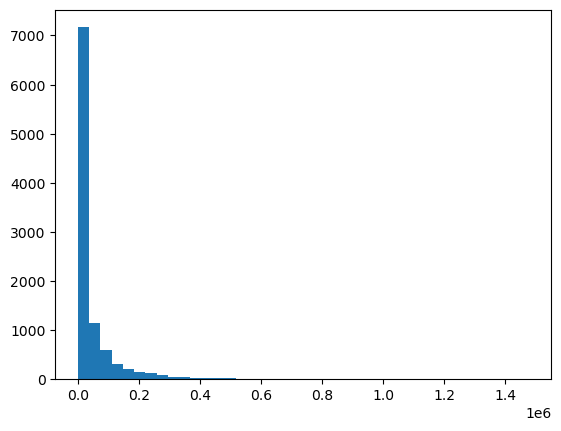

In [34]:
plt.hist(bins[:-1], bins=bins, weights=counts)

## Followers Count

In [35]:
bins, counts = twitterers_sample.select('followers_count').rdd.flatMap(lambda x: x).histogram(40)

(array([9.988e+03, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([       0. ,   443510.6,   887021.2,  1330531.8,  1774042.4,
         2217553. ,  2661063.6,  3104574.2,  3548084.8,  3991595.4,
         4435106. ,  4878616.6,  5322127.2,  5765637.8,  6209148.4,
         6652659. ,  7096169.6,  7539680.2,  7983190.8,  8426701.4,
         8870212. ,  9313722.6,  9757233.2, 10200743.8, 10644254.4,
        11087765. , 11531275.6, 11974786.2, 12418296.8, 12861807.4,
        13305318. , 13748828.6, 14192339.2, 14635849.8, 15079360.4,
        15522871. , 159663

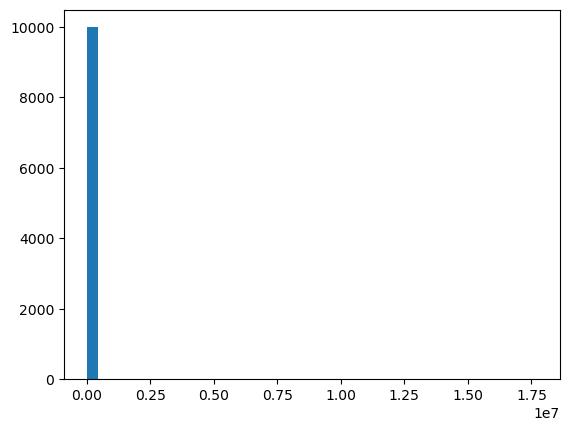

In [36]:
plt.hist(bins[:-1], bins = bins, weights = counts)

## Friends Count

In [37]:
bins, counts = twitterers_sample.select('friends_count').rdd.flatMap(lambda x: x).histogram(20)

(array([9.847e+03, 1.030e+02, 2.800e+01, 1.100e+01, 5.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([     0. ,   8948.2,  17896.4,  26844.6,  35792.8,  44741. ,
         53689.2,  62637.4,  71585.6,  80533.8,  89482. ,  98430.2,
        107378.4, 116326.6, 125274.8, 134223. , 143171.2, 152119.4,
        161067.6, 170015.8, 178964. ]),
 <BarContainer object of 20 artists>)

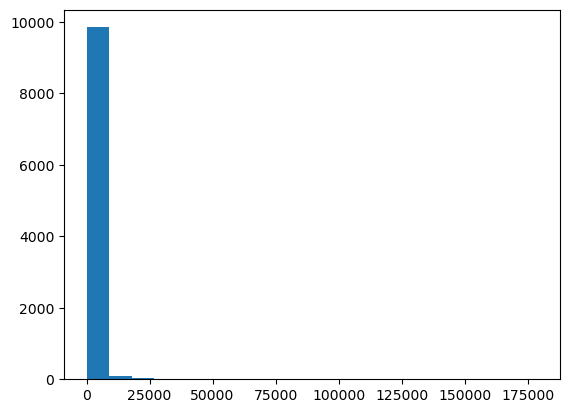

In [38]:
plt.hist(bins[:-1], bins=bins, weights=counts)

## Statuses Count

In [39]:
bins, counts = twitterers_sample.select('statuses_count').rdd.flatMap(lambda x: x).histogram(20)

(array([9.505e+03, 3.240e+02, 8.900e+01, 5.300e+01, 1.000e+01, 8.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00]),
 array([1.0000000e+00, 1.9626560e+05, 3.9253020e+05, 5.8879480e+05,
        7.8505940e+05, 9.8132400e+05, 1.1775886e+06, 1.3738532e+06,
        1.5701178e+06, 1.7663824e+06, 1.9626470e+06, 2.1589116e+06,
        2.3551762e+06, 2.5514408e+06, 2.7477054e+06, 2.9439700e+06,
        3.1402346e+06, 3.3364992e+06, 3.5327638e+06, 3.7290284e+06,
        3.9252930e+06]),
 <BarContainer object of 20 artists>)

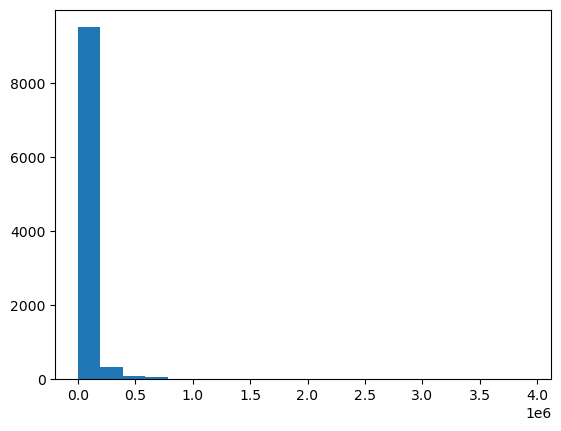

In [40]:
plt.hist(bins[:-1], bins=bins, weights=counts)

## Verified or not

In [41]:
df = twitterers_sample.groupby('verified').agg(count("*")).toPandas()
df

,verified,count(1)
0,False,9814
1,True,186


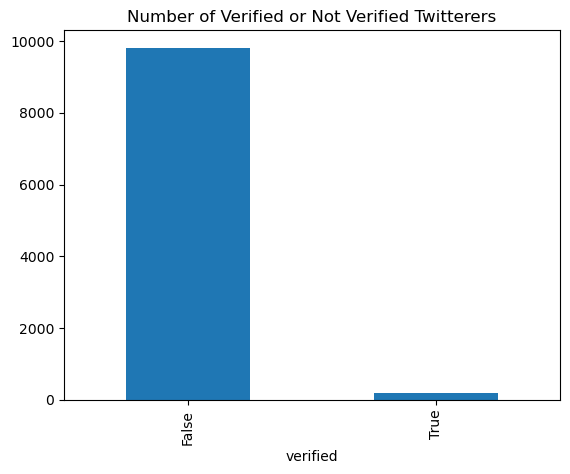

In [42]:
plot = df.plot(kind = 'bar',x = 'verified', y = 'count(1)', legend = None, title = "Number of Verified or Not Verified Twitterers")

# Save the Filterd Tweets As Parquet Files

In [44]:
dir_out = 'inter_result/filtered'

In [45]:
list_blobs_pd(bucket, dir_out)

,Name,Size


In [ ]:
#delete_folder(bucket, dir_out)

In [ ]:
#tweets_filtered.write.format("parquet").\
#    mode('overwrite').\
#    save('gs://' + bucket + '/' + dir_out)

In [47]:
blob_list = list_blobs_pd(bucket, dir_out)
blob_list.head(10)

,Name,Size
0,inter_result/filtered/,0
1,inter_result/filtered/_SUCCESS,0
2,inter_result/filtered/part-00000-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,79905281
3,inter_result/filtered/part-00001-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,79675239
4,inter_result/filtered/part-00002-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,79120751
5,inter_result/filtered/part-00003-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78856771
6,inter_result/filtered/part-00004-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78841226
7,inter_result/filtered/part-00005-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78763533
8,inter_result/filtered/part-00006-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78783569
9,inter_result/filtered/part-00007-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78734456
